In [1]:
import numpy as np
import gym
from keras.models import Model
from keras.layers import Input, Dense
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
ENV = 'CartPole-v1'
# CONTINUOUS = False
EPISODES = 10000
LOSS_CLIPPING = 0.2 # Only implemented clipping for the surrogate loss, paper said it was best
EPOCHS = 10
NOISE = 1.0 # Exploration noise
GAMMA = 0.99
BUFFER_SIZE = 2048
BATCH_SIZE = 256
NUM_ACTIONS = 2 #cartpole=2, acrobot = 3
NUM_STATE = 4 #cartpole =4,acrobot = 6
HIDDEN_SIZE = 128 #Cartpole 128, acrobot 256
NUM_LAYERS = 3 #cartpole = 2, #acrobot = 4
ENTROPY_LOSS = 5e-3
LR = 1e-4  # Lower lr stabilises training greatly
DUMMY_ACTION, DUMMY_VALUE = np.zeros((1, NUM_ACTIONS)), np.zeros((1, 1))

In [3]:
def ppo_loss(advantage, old_prediction):
    def loss(y_true, y_pred):
        prob = K.sum(y_true * y_pred, axis=-1)
        old_prob = K.sum(y_true * old_prediction, axis=-1)
        r = prob/(old_prob + 1e-10)
        return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantage) + ENTROPY_LOSS * -(prob * K.log(prob + 1e-10)))
    return loss

In [4]:
class Agent:
    def __init__(self):
        self.critic = self.build_critic()
        self.actor = self.build_actor()
        self.env = gym.make(ENV)
        self.episode = 0
        self.observation = self.env.reset()
        self.val = False
        self.reward = []
        self.reward_over_time = []
        self.gradient_steps = 0
        self.rewards_list = []

    def build_actor(self):
        state_input = Input(shape=(NUM_STATE,))
        advantage = Input(shape=(1,))
        old_prediction = Input(shape=(NUM_ACTIONS,))
        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)
        out_actions = Dense(NUM_ACTIONS, activation='softmax', name='output')(x)
        model = Model(inputs=[state_input, advantage, old_prediction], outputs=[out_actions])
        model.compile(optimizer=Adam(lr=LR),loss=[ppo_loss(advantage=advantage,old_prediction=old_prediction)])
        model.summary()
        return model

    def build_critic(self):
        state_input = Input(shape=(NUM_STATE,))
        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)
        out_value = Dense(1)(x)
        model = Model(inputs=[state_input], outputs=[out_value])
        model.compile(optimizer=Adam(lr=LR), loss='mse')
        return model

    def reset_env(self):
        self.episode += 1
        if self.episode % 100 == 0:
            self.val = True
        else:
            self.val = False
        self.observation = self.env.reset()
        self.reward = []

    def get_action(self):
        p = self.actor.predict([self.observation.reshape(1, NUM_STATE), DUMMY_VALUE, DUMMY_ACTION])
        if self.val is False:
            action = np.random.choice(NUM_ACTIONS, p=np.nan_to_num(p[0]))
        else:
            action = np.argmax(p[0])
        action_matrix = np.zeros(NUM_ACTIONS)
        action_matrix[action] = 1
        return action, action_matrix, p

    def transform_reward(self):
        print("episode=", self.episode)
        print('Reward=',np.sum(self.reward))
        self.rewards_list.append(np.sum(self.reward))
        for j in range(len(self.reward) - 2, -1, -1):
            self.reward[j] += self.reward[j + 1] * GAMMA

    def get_batch(self):
        batch = [[], [], [], []]

        tmp_batch = [[], [], []]
        while len(batch[0]) < BUFFER_SIZE:
            action, action_matrix, predicted_action = self.get_action()
            observation, reward, done, info = self.env.step(action)
            self.reward.append(reward)
            tmp_batch[0].append(self.observation)
            tmp_batch[1].append(action_matrix)
            tmp_batch[2].append(predicted_action)
            self.observation = observation

            if done:
                self.transform_reward()
                if self.val is False:
                    for i in range(len(tmp_batch[0])):
                        obs, action, pred = tmp_batch[0][i], tmp_batch[1][i], tmp_batch[2][i]
                        r = self.reward[i]
                        batch[0].append(obs)
                        batch[1].append(action)
                        batch[2].append(pred)
                        batch[3].append(r)
                tmp_batch = [[], [], []]
                self.reset_env()
        obs, action, pred, reward = np.array(batch[0]), np.array(batch[1]), np.array(batch[2]), np.reshape(np.array(batch[3]), (len(batch[3]), 1))
        pred = np.reshape(pred, (pred.shape[0], pred.shape[2]))
        return obs, action, pred, reward

    def run(self):
        rewards_list = []
        while self.episode < EPISODES:
            obs, action, pred, reward = self.get_batch()
            obs, action, pred, reward = obs[:BUFFER_SIZE], action[:BUFFER_SIZE], pred[:BUFFER_SIZE], reward[:BUFFER_SIZE]
            old_prediction = pred
            pred_values = self.critic.predict(obs)
            rewards_list.append(np.max(reward))
            advantage = reward - pred_values
            actor_loss = self.actor.fit([obs, advantage, old_prediction], [action], batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=False)
            critic_loss = self.critic.fit([obs], [reward], batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=False)
            self.gradient_steps += 1
        return self.rewards_list

In [5]:
ag = Agent()
rewards = ag.run()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 33,922
Trainable params: 33,922
Non-trainable params: 0
_________________________________________________________________

episode= 0
Reward= 16.0
episode= 1
Reward= 15.0
episode= 2
Reward= 21.0
episode= 3
Reward= 19.0
episode= 4
Reward= 15.0


episode= 272
Reward= 101.0
episode= 273
Reward= 35.0
episode= 274
Reward= 20.0
episode= 275
Reward= 15.0
episode= 276
Reward= 18.0
episode= 277
Reward= 13.0
episode= 278
Reward= 27.0
episode= 279
Reward= 16.0
episode= 280
Reward= 15.0
episode= 281
Reward= 16.0
episode= 282
Reward= 23.0
episode= 283
Reward= 15.0
episode= 284
Reward= 17.0
episode= 285
Reward= 12.0
episode= 286
Reward= 17.0
episode= 287
Reward= 14.0
episode= 288
Reward= 28.0
episode= 289
Reward= 24.0
episode= 290
Reward= 25.0
episode= 291
Reward= 12.0
episode= 292
Reward= 15.0
episode= 293
Reward= 17.0
episode= 294
Reward= 32.0
episode= 295
Reward= 48.0
episode= 296
Reward= 17.0
episode= 297
Reward= 78.0
episode= 298
Reward= 12.0
episode= 299
Reward= 12.0
episode= 300
Reward= 10.0
episode= 301
Reward= 18.0
episode= 302
Reward= 15.0
episode= 303
Reward= 32.0
episode= 304
Reward= 15.0
episode= 305
Reward= 15.0
episode= 306
Reward= 12.0
episode= 307
Reward= 37.0
episode= 308
Reward= 42.0
episode= 309
Reward= 25.0
episode= 31

episode= 597
Reward= 18.0
episode= 598
Reward= 28.0
episode= 599
Reward= 39.0
episode= 600
Reward= 34.0
episode= 601
Reward= 14.0
episode= 602
Reward= 20.0
episode= 603
Reward= 18.0
episode= 604
Reward= 52.0
episode= 605
Reward= 9.0
episode= 606
Reward= 15.0
episode= 607
Reward= 35.0
episode= 608
Reward= 13.0
episode= 609
Reward= 15.0
episode= 610
Reward= 34.0
episode= 611
Reward= 14.0
episode= 612
Reward= 28.0
episode= 613
Reward= 11.0
episode= 614
Reward= 18.0
episode= 615
Reward= 15.0
episode= 616
Reward= 30.0
episode= 617
Reward= 30.0
episode= 618
Reward= 35.0
episode= 619
Reward= 15.0
episode= 620
Reward= 28.0
episode= 621
Reward= 52.0
episode= 622
Reward= 55.0
episode= 623
Reward= 11.0
episode= 624
Reward= 60.0
episode= 625
Reward= 58.0
episode= 626
Reward= 45.0
episode= 627
Reward= 19.0
episode= 628
Reward= 34.0
episode= 629
Reward= 20.0
episode= 630
Reward= 26.0
episode= 631
Reward= 13.0
episode= 632
Reward= 22.0
episode= 633
Reward= 20.0
episode= 634
Reward= 21.0
episode= 635


episode= 913
Reward= 29.0
episode= 914
Reward= 50.0
episode= 915
Reward= 54.0
episode= 916
Reward= 24.0
episode= 917
Reward= 43.0
episode= 918
Reward= 10.0
episode= 919
Reward= 34.0
episode= 920
Reward= 28.0
episode= 921
Reward= 16.0
episode= 922
Reward= 29.0
episode= 923
Reward= 14.0
episode= 924
Reward= 24.0
episode= 925
Reward= 22.0
episode= 926
Reward= 60.0
episode= 927
Reward= 79.0
episode= 928
Reward= 51.0
episode= 929
Reward= 71.0
episode= 930
Reward= 101.0
episode= 931
Reward= 65.0
episode= 932
Reward= 65.0
episode= 933
Reward= 35.0
episode= 934
Reward= 39.0
episode= 935
Reward= 15.0
episode= 936
Reward= 42.0
episode= 937
Reward= 17.0
episode= 938
Reward= 46.0
episode= 939
Reward= 13.0
episode= 940
Reward= 29.0
episode= 941
Reward= 64.0
episode= 942
Reward= 27.0
episode= 943
Reward= 68.0
episode= 944
Reward= 39.0
episode= 945
Reward= 22.0
episode= 946
Reward= 36.0
episode= 947
Reward= 18.0
episode= 948
Reward= 30.0
episode= 949
Reward= 46.0
episode= 950
Reward= 23.0
episode= 95

episode= 1225
Reward= 49.0
episode= 1226
Reward= 32.0
episode= 1227
Reward= 110.0
episode= 1228
Reward= 53.0
episode= 1229
Reward= 49.0
episode= 1230
Reward= 38.0
episode= 1231
Reward= 66.0
episode= 1232
Reward= 11.0
episode= 1233
Reward= 30.0
episode= 1234
Reward= 104.0
episode= 1235
Reward= 36.0
episode= 1236
Reward= 65.0
episode= 1237
Reward= 28.0
episode= 1238
Reward= 34.0
episode= 1239
Reward= 39.0
episode= 1240
Reward= 23.0
episode= 1241
Reward= 45.0
episode= 1242
Reward= 19.0
episode= 1243
Reward= 36.0
episode= 1244
Reward= 22.0
episode= 1245
Reward= 110.0
episode= 1246
Reward= 23.0
episode= 1247
Reward= 40.0
episode= 1248
Reward= 31.0
episode= 1249
Reward= 30.0
episode= 1250
Reward= 17.0
episode= 1251
Reward= 26.0
episode= 1252
Reward= 37.0
episode= 1253
Reward= 67.0
episode= 1254
Reward= 57.0
episode= 1255
Reward= 41.0
episode= 1256
Reward= 54.0
episode= 1257
Reward= 29.0
episode= 1258
Reward= 32.0
episode= 1259
Reward= 33.0
episode= 1260
Reward= 64.0
episode= 1261
Reward= 20.

episode= 1535
Reward= 67.0
episode= 1536
Reward= 19.0
episode= 1537
Reward= 41.0
episode= 1538
Reward= 52.0
episode= 1539
Reward= 55.0
episode= 1540
Reward= 15.0
episode= 1541
Reward= 42.0
episode= 1542
Reward= 17.0
episode= 1543
Reward= 56.0
episode= 1544
Reward= 34.0
episode= 1545
Reward= 37.0
episode= 1546
Reward= 32.0
episode= 1547
Reward= 72.0
episode= 1548
Reward= 20.0
episode= 1549
Reward= 51.0
episode= 1550
Reward= 39.0
episode= 1551
Reward= 54.0
episode= 1552
Reward= 53.0
episode= 1553
Reward= 30.0
episode= 1554
Reward= 31.0
episode= 1555
Reward= 43.0
episode= 1556
Reward= 22.0
episode= 1557
Reward= 35.0
episode= 1558
Reward= 30.0
episode= 1559
Reward= 95.0
episode= 1560
Reward= 25.0
episode= 1561
Reward= 38.0
episode= 1562
Reward= 50.0
episode= 1563
Reward= 75.0
episode= 1564
Reward= 27.0
episode= 1565
Reward= 55.0
episode= 1566
Reward= 98.0
episode= 1567
Reward= 137.0
episode= 1568
Reward= 33.0
episode= 1569
Reward= 77.0
episode= 1570
Reward= 24.0
episode= 1571
Reward= 59.0


episode= 1843
Reward= 176.0
episode= 1844
Reward= 65.0
episode= 1845
Reward= 47.0
episode= 1846
Reward= 49.0
episode= 1847
Reward= 29.0
episode= 1848
Reward= 61.0
episode= 1849
Reward= 42.0
episode= 1850
Reward= 49.0
episode= 1851
Reward= 44.0
episode= 1852
Reward= 51.0
episode= 1853
Reward= 54.0
episode= 1854
Reward= 53.0
episode= 1855
Reward= 82.0
episode= 1856
Reward= 61.0
episode= 1857
Reward= 39.0
episode= 1858
Reward= 31.0
episode= 1859
Reward= 50.0
episode= 1860
Reward= 74.0
episode= 1861
Reward= 66.0
episode= 1862
Reward= 68.0
episode= 1863
Reward= 25.0
episode= 1864
Reward= 80.0
episode= 1865
Reward= 56.0
episode= 1866
Reward= 23.0
episode= 1867
Reward= 68.0
episode= 1868
Reward= 35.0
episode= 1869
Reward= 84.0
episode= 1870
Reward= 79.0
episode= 1871
Reward= 40.0
episode= 1872
Reward= 44.0
episode= 1873
Reward= 99.0
episode= 1874
Reward= 69.0
episode= 1875
Reward= 44.0
episode= 1876
Reward= 52.0
episode= 1877
Reward= 107.0
episode= 1878
Reward= 72.0
episode= 1879
Reward= 40.0

episode= 2145
Reward= 162.0
episode= 2146
Reward= 24.0
episode= 2147
Reward= 37.0
episode= 2148
Reward= 57.0
episode= 2149
Reward= 141.0
episode= 2150
Reward= 180.0
episode= 2151
Reward= 167.0
episode= 2152
Reward= 41.0
episode= 2153
Reward= 39.0
episode= 2154
Reward= 156.0
episode= 2155
Reward= 49.0
episode= 2156
Reward= 123.0
episode= 2157
Reward= 145.0
episode= 2158
Reward= 103.0
episode= 2159
Reward= 122.0
episode= 2160
Reward= 115.0
episode= 2161
Reward= 230.0
episode= 2162
Reward= 104.0
episode= 2163
Reward= 155.0
episode= 2164
Reward= 51.0
episode= 2165
Reward= 126.0
episode= 2166
Reward= 68.0
episode= 2167
Reward= 80.0
episode= 2168
Reward= 75.0
episode= 2169
Reward= 285.0
episode= 2170
Reward= 145.0
episode= 2171
Reward= 141.0
episode= 2172
Reward= 402.0
episode= 2173
Reward= 129.0
episode= 2174
Reward= 115.0
episode= 2175
Reward= 140.0
episode= 2176
Reward= 76.0
episode= 2177
Reward= 128.0
episode= 2178
Reward= 209.0
episode= 2179
Reward= 157.0
episode= 2180
Reward= 50.0
epis

episode= 2439
Reward= 181.0
episode= 2440
Reward= 191.0
episode= 2441
Reward= 178.0
episode= 2442
Reward= 312.0
episode= 2443
Reward= 320.0
episode= 2444
Reward= 330.0
episode= 2445
Reward= 196.0
episode= 2446
Reward= 317.0
episode= 2447
Reward= 160.0
episode= 2448
Reward= 285.0
episode= 2449
Reward= 131.0
episode= 2450
Reward= 207.0
episode= 2451
Reward= 180.0
episode= 2452
Reward= 207.0
episode= 2453
Reward= 157.0
episode= 2454
Reward= 167.0
episode= 2455
Reward= 196.0
episode= 2456
Reward= 159.0
episode= 2457
Reward= 340.0
episode= 2458
Reward= 168.0
episode= 2459
Reward= 145.0
episode= 2460
Reward= 272.0
episode= 2461
Reward= 331.0
episode= 2462
Reward= 315.0
episode= 2463
Reward= 331.0
episode= 2464
Reward= 157.0
episode= 2465
Reward= 151.0
episode= 2466
Reward= 354.0
episode= 2467
Reward= 214.0
episode= 2468
Reward= 314.0
episode= 2469
Reward= 210.0
episode= 2470
Reward= 290.0
episode= 2471
Reward= 189.0
episode= 2472
Reward= 303.0
episode= 2473
Reward= 230.0
episode= 2474
Reward

episode= 2732
Reward= 500.0
episode= 2733
Reward= 284.0
episode= 2734
Reward= 500.0
episode= 2735
Reward= 222.0
episode= 2736
Reward= 235.0
episode= 2737
Reward= 181.0
episode= 2738
Reward= 451.0
episode= 2739
Reward= 500.0
episode= 2740
Reward= 248.0
episode= 2741
Reward= 376.0
episode= 2742
Reward= 500.0
episode= 2743
Reward= 169.0
episode= 2744
Reward= 500.0
episode= 2745
Reward= 166.0
episode= 2746
Reward= 500.0
episode= 2747
Reward= 210.0
episode= 2748
Reward= 500.0
episode= 2749
Reward= 264.0
episode= 2750
Reward= 278.0
episode= 2751
Reward= 179.0
episode= 2752
Reward= 500.0
episode= 2753
Reward= 227.0
episode= 2754
Reward= 256.0
episode= 2755
Reward= 253.0
episode= 2756
Reward= 500.0
episode= 2757
Reward= 262.0
episode= 2758
Reward= 168.0
episode= 2759
Reward= 500.0
episode= 2760
Reward= 225.0
episode= 2761
Reward= 212.0
episode= 2762
Reward= 224.0
episode= 2763
Reward= 155.0
episode= 2764
Reward= 203.0
episode= 2765
Reward= 167.0
episode= 2766
Reward= 220.0
episode= 2767
Reward

episode= 3025
Reward= 214.0
episode= 3026
Reward= 253.0
episode= 3027
Reward= 500.0
episode= 3028
Reward= 207.0
episode= 3029
Reward= 265.0
episode= 3030
Reward= 453.0
episode= 3031
Reward= 500.0
episode= 3032
Reward= 331.0
episode= 3033
Reward= 361.0
episode= 3034
Reward= 500.0
episode= 3035
Reward= 257.0
episode= 3036
Reward= 484.0
episode= 3037
Reward= 399.0
episode= 3038
Reward= 500.0
episode= 3039
Reward= 156.0
episode= 3040
Reward= 435.0
episode= 3041
Reward= 421.0
episode= 3042
Reward= 339.0
episode= 3043
Reward= 357.0
episode= 3044
Reward= 500.0
episode= 3045
Reward= 500.0
episode= 3046
Reward= 433.0
episode= 3047
Reward= 205.0
episode= 3048
Reward= 500.0
episode= 3049
Reward= 216.0
episode= 3050
Reward= 461.0
episode= 3051
Reward= 500.0
episode= 3052
Reward= 500.0
episode= 3053
Reward= 410.0
episode= 3054
Reward= 250.0
episode= 3055
Reward= 500.0
episode= 3056
Reward= 153.0
episode= 3057
Reward= 463.0
episode= 3058
Reward= 401.0
episode= 3059
Reward= 410.0
episode= 3060
Reward

episode= 3318
Reward= 485.0
episode= 3319
Reward= 500.0
episode= 3320
Reward= 500.0
episode= 3321
Reward= 500.0
episode= 3322
Reward= 500.0
episode= 3323
Reward= 500.0
episode= 3324
Reward= 298.0
episode= 3325
Reward= 228.0
episode= 3326
Reward= 212.0
episode= 3327
Reward= 500.0
episode= 3328
Reward= 500.0
episode= 3329
Reward= 500.0
episode= 3330
Reward= 179.0
episode= 3331
Reward= 500.0
episode= 3332
Reward= 500.0
episode= 3333
Reward= 500.0
episode= 3334
Reward= 310.0
episode= 3335
Reward= 261.0
episode= 3336
Reward= 500.0
episode= 3337
Reward= 253.0
episode= 3338
Reward= 499.0
episode= 3339
Reward= 500.0
episode= 3340
Reward= 500.0
episode= 3341
Reward= 190.0
episode= 3342
Reward= 247.0
episode= 3343
Reward= 186.0
episode= 3344
Reward= 468.0
episode= 3345
Reward= 206.0
episode= 3346
Reward= 289.0
episode= 3347
Reward= 500.0
episode= 3348
Reward= 500.0
episode= 3349
Reward= 482.0
episode= 3350
Reward= 268.0
episode= 3351
Reward= 243.0
episode= 3352
Reward= 197.0
episode= 3353
Reward

episode= 3611
Reward= 481.0
episode= 3612
Reward= 500.0
episode= 3613
Reward= 500.0
episode= 3614
Reward= 268.0
episode= 3615
Reward= 432.0
episode= 3616
Reward= 500.0
episode= 3617
Reward= 500.0
episode= 3618
Reward= 472.0
episode= 3619
Reward= 238.0
episode= 3620
Reward= 276.0
episode= 3621
Reward= 244.0
episode= 3622
Reward= 500.0
episode= 3623
Reward= 184.0
episode= 3624
Reward= 241.0
episode= 3625
Reward= 390.0
episode= 3626
Reward= 484.0
episode= 3627
Reward= 449.0
episode= 3628
Reward= 193.0
episode= 3629
Reward= 500.0
episode= 3630
Reward= 500.0
episode= 3631
Reward= 468.0
episode= 3632
Reward= 209.0
episode= 3633
Reward= 500.0
episode= 3634
Reward= 434.0
episode= 3635
Reward= 464.0
episode= 3636
Reward= 281.0
episode= 3637
Reward= 500.0
episode= 3638
Reward= 500.0
episode= 3639
Reward= 500.0
episode= 3640
Reward= 500.0
episode= 3641
Reward= 444.0
episode= 3642
Reward= 469.0
episode= 3643
Reward= 499.0
episode= 3644
Reward= 500.0
episode= 3645
Reward= 500.0
episode= 3646
Reward

episode= 3904
Reward= 500.0
episode= 3905
Reward= 336.0
episode= 3906
Reward= 500.0
episode= 3907
Reward= 176.0
episode= 3908
Reward= 500.0
episode= 3909
Reward= 391.0
episode= 3910
Reward= 500.0
episode= 3911
Reward= 397.0
episode= 3912
Reward= 169.0
episode= 3913
Reward= 500.0
episode= 3914
Reward= 500.0
episode= 3915
Reward= 500.0
episode= 3916
Reward= 500.0
episode= 3917
Reward= 500.0
episode= 3918
Reward= 495.0
episode= 3919
Reward= 500.0
episode= 3920
Reward= 500.0
episode= 3921
Reward= 435.0
episode= 3922
Reward= 500.0
episode= 3923
Reward= 500.0
episode= 3924
Reward= 500.0
episode= 3925
Reward= 431.0
episode= 3926
Reward= 500.0
episode= 3927
Reward= 499.0
episode= 3928
Reward= 496.0
episode= 3929
Reward= 500.0
episode= 3930
Reward= 293.0
episode= 3931
Reward= 269.0
episode= 3932
Reward= 500.0
episode= 3933
Reward= 500.0
episode= 3934
Reward= 191.0
episode= 3935
Reward= 334.0
episode= 3936
Reward= 500.0
episode= 3937
Reward= 500.0
episode= 3938
Reward= 500.0
episode= 3939
Reward

episode= 4197
Reward= 426.0
episode= 4198
Reward= 409.0
episode= 4199
Reward= 357.0
episode= 4200
Reward= 500.0
episode= 4201
Reward= 500.0
episode= 4202
Reward= 347.0
episode= 4203
Reward= 500.0
episode= 4204
Reward= 500.0
episode= 4205
Reward= 491.0
episode= 4206
Reward= 500.0
episode= 4207
Reward= 500.0
episode= 4208
Reward= 500.0
episode= 4209
Reward= 403.0
episode= 4210
Reward= 500.0
episode= 4211
Reward= 450.0
episode= 4212
Reward= 500.0
episode= 4213
Reward= 321.0
episode= 4214
Reward= 500.0
episode= 4215
Reward= 500.0
episode= 4216
Reward= 500.0
episode= 4217
Reward= 322.0
episode= 4218
Reward= 500.0
episode= 4219
Reward= 500.0
episode= 4220
Reward= 500.0
episode= 4221
Reward= 500.0
episode= 4222
Reward= 500.0
episode= 4223
Reward= 500.0
episode= 4224
Reward= 500.0
episode= 4225
Reward= 500.0
episode= 4226
Reward= 297.0
episode= 4227
Reward= 500.0
episode= 4228
Reward= 500.0
episode= 4229
Reward= 421.0
episode= 4230
Reward= 500.0
episode= 4231
Reward= 267.0
episode= 4232
Reward

episode= 4490
Reward= 500.0
episode= 4491
Reward= 500.0
episode= 4492
Reward= 300.0
episode= 4493
Reward= 393.0
episode= 4494
Reward= 342.0
episode= 4495
Reward= 290.0
episode= 4496
Reward= 500.0
episode= 4497
Reward= 500.0
episode= 4498
Reward= 500.0
episode= 4499
Reward= 381.0
episode= 4500
Reward= 430.0
episode= 4501
Reward= 500.0
episode= 4502
Reward= 371.0
episode= 4503
Reward= 436.0
episode= 4504
Reward= 180.0
episode= 4505
Reward= 449.0
episode= 4506
Reward= 500.0
episode= 4507
Reward= 500.0
episode= 4508
Reward= 499.0
episode= 4509
Reward= 298.0
episode= 4510
Reward= 293.0
episode= 4511
Reward= 500.0
episode= 4512
Reward= 500.0
episode= 4513
Reward= 433.0
episode= 4514
Reward= 500.0
episode= 4515
Reward= 500.0
episode= 4516
Reward= 431.0
episode= 4517
Reward= 280.0
episode= 4518
Reward= 141.0
episode= 4519
Reward= 500.0
episode= 4520
Reward= 500.0
episode= 4521
Reward= 159.0
episode= 4522
Reward= 471.0
episode= 4523
Reward= 500.0
episode= 4524
Reward= 500.0
episode= 4525
Reward

episode= 4783
Reward= 500.0
episode= 4784
Reward= 500.0
episode= 4785
Reward= 500.0
episode= 4786
Reward= 462.0
episode= 4787
Reward= 313.0
episode= 4788
Reward= 329.0
episode= 4789
Reward= 500.0
episode= 4790
Reward= 500.0
episode= 4791
Reward= 304.0
episode= 4792
Reward= 317.0
episode= 4793
Reward= 407.0
episode= 4794
Reward= 463.0
episode= 4795
Reward= 500.0
episode= 4796
Reward= 359.0
episode= 4797
Reward= 500.0
episode= 4798
Reward= 391.0
episode= 4799
Reward= 267.0
episode= 4800
Reward= 500.0
episode= 4801
Reward= 365.0
episode= 4802
Reward= 393.0
episode= 4803
Reward= 367.0
episode= 4804
Reward= 315.0
episode= 4805
Reward= 478.0
episode= 4806
Reward= 269.0
episode= 4807
Reward= 500.0
episode= 4808
Reward= 421.0
episode= 4809
Reward= 320.0
episode= 4810
Reward= 402.0
episode= 4811
Reward= 500.0
episode= 4812
Reward= 500.0
episode= 4813
Reward= 500.0
episode= 4814
Reward= 500.0
episode= 4815
Reward= 438.0
episode= 4816
Reward= 500.0
episode= 4817
Reward= 386.0
episode= 4818
Reward

episode= 5076
Reward= 279.0
episode= 5077
Reward= 477.0
episode= 5078
Reward= 500.0
episode= 5079
Reward= 500.0
episode= 5080
Reward= 500.0
episode= 5081
Reward= 292.0
episode= 5082
Reward= 500.0
episode= 5083
Reward= 500.0
episode= 5084
Reward= 500.0
episode= 5085
Reward= 453.0
episode= 5086
Reward= 427.0
episode= 5087
Reward= 500.0
episode= 5088
Reward= 500.0
episode= 5089
Reward= 500.0
episode= 5090
Reward= 500.0
episode= 5091
Reward= 500.0
episode= 5092
Reward= 500.0
episode= 5093
Reward= 481.0
episode= 5094
Reward= 436.0
episode= 5095
Reward= 500.0
episode= 5096
Reward= 487.0
episode= 5097
Reward= 500.0
episode= 5098
Reward= 319.0
episode= 5099
Reward= 465.0
episode= 5100
Reward= 479.0
episode= 5101
Reward= 160.0
episode= 5102
Reward= 500.0
episode= 5103
Reward= 474.0
episode= 5104
Reward= 415.0
episode= 5105
Reward= 396.0
episode= 5106
Reward= 342.0
episode= 5107
Reward= 500.0
episode= 5108
Reward= 296.0
episode= 5109
Reward= 343.0
episode= 5110
Reward= 345.0
episode= 5111
Reward

episode= 5369
Reward= 500.0
episode= 5370
Reward= 500.0
episode= 5371
Reward= 500.0
episode= 5372
Reward= 388.0
episode= 5373
Reward= 484.0
episode= 5374
Reward= 500.0
episode= 5375
Reward= 500.0
episode= 5376
Reward= 500.0
episode= 5377
Reward= 494.0
episode= 5378
Reward= 500.0
episode= 5379
Reward= 484.0
episode= 5380
Reward= 500.0
episode= 5381
Reward= 500.0
episode= 5382
Reward= 500.0
episode= 5383
Reward= 500.0
episode= 5384
Reward= 500.0
episode= 5385
Reward= 500.0
episode= 5386
Reward= 480.0
episode= 5387
Reward= 500.0
episode= 5388
Reward= 476.0
episode= 5389
Reward= 500.0
episode= 5390
Reward= 500.0
episode= 5391
Reward= 496.0
episode= 5392
Reward= 439.0
episode= 5393
Reward= 489.0
episode= 5394
Reward= 461.0
episode= 5395
Reward= 470.0
episode= 5396
Reward= 500.0
episode= 5397
Reward= 468.0
episode= 5398
Reward= 500.0
episode= 5399
Reward= 500.0
episode= 5400
Reward= 500.0
episode= 5401
Reward= 500.0
episode= 5402
Reward= 479.0
episode= 5403
Reward= 488.0
episode= 5404
Reward

episode= 5662
Reward= 500.0
episode= 5663
Reward= 500.0
episode= 5664
Reward= 500.0
episode= 5665
Reward= 500.0
episode= 5666
Reward= 500.0
episode= 5667
Reward= 500.0
episode= 5668
Reward= 500.0
episode= 5669
Reward= 500.0
episode= 5670
Reward= 500.0
episode= 5671
Reward= 500.0
episode= 5672
Reward= 186.0
episode= 5673
Reward= 492.0
episode= 5674
Reward= 444.0
episode= 5675
Reward= 500.0
episode= 5676
Reward= 485.0
episode= 5677
Reward= 500.0
episode= 5678
Reward= 500.0
episode= 5679
Reward= 500.0
episode= 5680
Reward= 458.0
episode= 5681
Reward= 500.0
episode= 5682
Reward= 461.0
episode= 5683
Reward= 500.0
episode= 5684
Reward= 458.0
episode= 5685
Reward= 325.0
episode= 5686
Reward= 500.0
episode= 5687
Reward= 472.0
episode= 5688
Reward= 500.0
episode= 5689
Reward= 500.0
episode= 5690
Reward= 500.0
episode= 5691
Reward= 500.0
episode= 5692
Reward= 472.0
episode= 5693
Reward= 500.0
episode= 5694
Reward= 447.0
episode= 5695
Reward= 497.0
episode= 5696
Reward= 444.0
episode= 5697
Reward

episode= 5955
Reward= 500.0
episode= 5956
Reward= 495.0
episode= 5957
Reward= 481.0
episode= 5958
Reward= 483.0
episode= 5959
Reward= 158.0
episode= 5960
Reward= 499.0
episode= 5961
Reward= 500.0
episode= 5962
Reward= 257.0
episode= 5963
Reward= 483.0
episode= 5964
Reward= 500.0
episode= 5965
Reward= 500.0
episode= 5966
Reward= 192.0
episode= 5967
Reward= 256.0
episode= 5968
Reward= 248.0
episode= 5969
Reward= 500.0
episode= 5970
Reward= 500.0
episode= 5971
Reward= 211.0
episode= 5972
Reward= 481.0
episode= 5973
Reward= 316.0
episode= 5974
Reward= 500.0
episode= 5975
Reward= 500.0
episode= 5976
Reward= 254.0
episode= 5977
Reward= 483.0
episode= 5978
Reward= 484.0
episode= 5979
Reward= 470.0
episode= 5980
Reward= 298.0
episode= 5981
Reward= 500.0
episode= 5982
Reward= 500.0
episode= 5983
Reward= 309.0
episode= 5984
Reward= 478.0
episode= 5985
Reward= 484.0
episode= 5986
Reward= 500.0
episode= 5987
Reward= 187.0
episode= 5988
Reward= 500.0
episode= 5989
Reward= 460.0
episode= 5990
Reward

episode= 6248
Reward= 399.0
episode= 6249
Reward= 391.0
episode= 6250
Reward= 500.0
episode= 6251
Reward= 500.0
episode= 6252
Reward= 500.0
episode= 6253
Reward= 414.0
episode= 6254
Reward= 440.0
episode= 6255
Reward= 261.0
episode= 6256
Reward= 421.0
episode= 6257
Reward= 415.0
episode= 6258
Reward= 456.0
episode= 6259
Reward= 462.0
episode= 6260
Reward= 372.0
episode= 6261
Reward= 464.0
episode= 6262
Reward= 441.0
episode= 6263
Reward= 260.0
episode= 6264
Reward= 238.0
episode= 6265
Reward= 442.0
episode= 6266
Reward= 449.0
episode= 6267
Reward= 484.0
episode= 6268
Reward= 500.0
episode= 6269
Reward= 460.0
episode= 6270
Reward= 500.0
episode= 6271
Reward= 405.0
episode= 6272
Reward= 366.0
episode= 6273
Reward= 472.0
episode= 6274
Reward= 433.0
episode= 6275
Reward= 433.0
episode= 6276
Reward= 442.0
episode= 6277
Reward= 451.0
episode= 6278
Reward= 446.0
episode= 6279
Reward= 493.0
episode= 6280
Reward= 427.0
episode= 6281
Reward= 435.0
episode= 6282
Reward= 448.0
episode= 6283
Reward

episode= 6541
Reward= 348.0
episode= 6542
Reward= 315.0
episode= 6543
Reward= 452.0
episode= 6544
Reward= 395.0
episode= 6545
Reward= 421.0
episode= 6546
Reward= 300.0
episode= 6547
Reward= 311.0
episode= 6548
Reward= 385.0
episode= 6549
Reward= 309.0
episode= 6550
Reward= 500.0
episode= 6551
Reward= 403.0
episode= 6552
Reward= 338.0
episode= 6553
Reward= 151.0
episode= 6554
Reward= 431.0
episode= 6555
Reward= 500.0
episode= 6556
Reward= 358.0
episode= 6557
Reward= 365.0
episode= 6558
Reward= 388.0
episode= 6559
Reward= 439.0
episode= 6560
Reward= 386.0
episode= 6561
Reward= 321.0
episode= 6562
Reward= 332.0
episode= 6563
Reward= 500.0
episode= 6564
Reward= 361.0
episode= 6565
Reward= 359.0
episode= 6566
Reward= 379.0
episode= 6567
Reward= 300.0
episode= 6568
Reward= 387.0
episode= 6569
Reward= 345.0
episode= 6570
Reward= 431.0
episode= 6571
Reward= 411.0
episode= 6572
Reward= 337.0
episode= 6573
Reward= 500.0
episode= 6574
Reward= 477.0
episode= 6575
Reward= 337.0
episode= 6576
Reward

episode= 6835
Reward= 336.0
episode= 6836
Reward= 500.0
episode= 6837
Reward= 469.0
episode= 6838
Reward= 266.0
episode= 6839
Reward= 356.0
episode= 6840
Reward= 369.0
episode= 6841
Reward= 243.0
episode= 6842
Reward= 500.0
episode= 6843
Reward= 229.0
episode= 6844
Reward= 370.0
episode= 6845
Reward= 489.0
episode= 6846
Reward= 337.0
episode= 6847
Reward= 447.0
episode= 6848
Reward= 448.0
episode= 6849
Reward= 433.0
episode= 6850
Reward= 359.0
episode= 6851
Reward= 227.0
episode= 6852
Reward= 321.0
episode= 6853
Reward= 487.0
episode= 6854
Reward= 405.0
episode= 6855
Reward= 321.0
episode= 6856
Reward= 418.0
episode= 6857
Reward= 343.0
episode= 6858
Reward= 224.0
episode= 6859
Reward= 352.0
episode= 6860
Reward= 450.0
episode= 6861
Reward= 310.0
episode= 6862
Reward= 269.0
episode= 6863
Reward= 243.0
episode= 6864
Reward= 378.0
episode= 6865
Reward= 229.0
episode= 6866
Reward= 336.0
episode= 6867
Reward= 322.0
episode= 6868
Reward= 365.0
episode= 6869
Reward= 223.0
episode= 6870
Reward

episode= 7129
Reward= 403.0
episode= 7130
Reward= 403.0
episode= 7131
Reward= 433.0
episode= 7132
Reward= 425.0
episode= 7133
Reward= 391.0
episode= 7134
Reward= 500.0
episode= 7135
Reward= 399.0
episode= 7136
Reward= 268.0
episode= 7137
Reward= 323.0
episode= 7138
Reward= 399.0
episode= 7139
Reward= 476.0
episode= 7140
Reward= 406.0
episode= 7141
Reward= 478.0
episode= 7142
Reward= 500.0
episode= 7143
Reward= 294.0
episode= 7144
Reward= 374.0
episode= 7145
Reward= 330.0
episode= 7146
Reward= 349.0
episode= 7147
Reward= 430.0
episode= 7148
Reward= 363.0
episode= 7149
Reward= 443.0
episode= 7150
Reward= 361.0
episode= 7151
Reward= 357.0
episode= 7152
Reward= 500.0
episode= 7153
Reward= 380.0
episode= 7154
Reward= 452.0
episode= 7155
Reward= 451.0
episode= 7156
Reward= 358.0
episode= 7157
Reward= 484.0
episode= 7158
Reward= 357.0
episode= 7159
Reward= 406.0
episode= 7160
Reward= 324.0
episode= 7161
Reward= 500.0
episode= 7162
Reward= 467.0
episode= 7163
Reward= 428.0
episode= 7164
Reward

episode= 7422
Reward= 470.0
episode= 7423
Reward= 268.0
episode= 7424
Reward= 500.0
episode= 7425
Reward= 420.0
episode= 7426
Reward= 216.0
episode= 7427
Reward= 496.0
episode= 7428
Reward= 500.0
episode= 7429
Reward= 500.0
episode= 7430
Reward= 436.0
episode= 7431
Reward= 500.0
episode= 7432
Reward= 450.0
episode= 7433
Reward= 496.0
episode= 7434
Reward= 355.0
episode= 7435
Reward= 429.0
episode= 7436
Reward= 481.0
episode= 7437
Reward= 448.0
episode= 7438
Reward= 427.0
episode= 7439
Reward= 500.0
episode= 7440
Reward= 500.0
episode= 7441
Reward= 419.0
episode= 7442
Reward= 433.0
episode= 7443
Reward= 500.0
episode= 7444
Reward= 500.0
episode= 7445
Reward= 500.0
episode= 7446
Reward= 254.0
episode= 7447
Reward= 459.0
episode= 7448
Reward= 493.0
episode= 7449
Reward= 465.0
episode= 7450
Reward= 478.0
episode= 7451
Reward= 472.0
episode= 7452
Reward= 500.0
episode= 7453
Reward= 449.0
episode= 7454
Reward= 500.0
episode= 7455
Reward= 439.0
episode= 7456
Reward= 272.0
episode= 7457
Reward

episode= 7716
Reward= 500.0
episode= 7717
Reward= 422.0
episode= 7718
Reward= 328.0
episode= 7719
Reward= 500.0
episode= 7720
Reward= 262.0
episode= 7721
Reward= 485.0
episode= 7722
Reward= 450.0
episode= 7723
Reward= 427.0
episode= 7724
Reward= 500.0
episode= 7725
Reward= 414.0
episode= 7726
Reward= 500.0
episode= 7727
Reward= 269.0
episode= 7728
Reward= 480.0
episode= 7729
Reward= 463.0
episode= 7730
Reward= 319.0
episode= 7731
Reward= 430.0
episode= 7732
Reward= 334.0
episode= 7733
Reward= 437.0
episode= 7734
Reward= 322.0
episode= 7735
Reward= 429.0
episode= 7736
Reward= 419.0
episode= 7737
Reward= 321.0
episode= 7738
Reward= 405.0
episode= 7739
Reward= 409.0
episode= 7740
Reward= 386.0
episode= 7741
Reward= 398.0
episode= 7742
Reward= 500.0
episode= 7743
Reward= 500.0
episode= 7744
Reward= 329.0
episode= 7745
Reward= 443.0
episode= 7746
Reward= 470.0
episode= 7747
Reward= 398.0
episode= 7748
Reward= 452.0
episode= 7749
Reward= 420.0
episode= 7750
Reward= 500.0
episode= 7751
Reward

episode= 8009
Reward= 427.0
episode= 8010
Reward= 381.0
episode= 8011
Reward= 500.0
episode= 8012
Reward= 360.0
episode= 8013
Reward= 462.0
episode= 8014
Reward= 434.0
episode= 8015
Reward= 398.0
episode= 8016
Reward= 384.0
episode= 8017
Reward= 187.0
episode= 8018
Reward= 334.0
episode= 8019
Reward= 500.0
episode= 8020
Reward= 447.0
episode= 8021
Reward= 422.0
episode= 8022
Reward= 340.0
episode= 8023
Reward= 353.0
episode= 8024
Reward= 352.0
episode= 8025
Reward= 382.0
episode= 8026
Reward= 323.0
episode= 8027
Reward= 500.0
episode= 8028
Reward= 500.0
episode= 8029
Reward= 500.0
episode= 8030
Reward= 351.0
episode= 8031
Reward= 331.0
episode= 8032
Reward= 450.0
episode= 8033
Reward= 454.0
episode= 8034
Reward= 452.0
episode= 8035
Reward= 465.0
episode= 8036
Reward= 425.0
episode= 8037
Reward= 443.0
episode= 8038
Reward= 376.0
episode= 8039
Reward= 337.0
episode= 8040
Reward= 498.0
episode= 8041
Reward= 433.0
episode= 8042
Reward= 500.0
episode= 8043
Reward= 456.0
episode= 8044
Reward

episode= 8302
Reward= 431.0
episode= 8303
Reward= 323.0
episode= 8304
Reward= 390.0
episode= 8305
Reward= 465.0
episode= 8306
Reward= 344.0
episode= 8307
Reward= 445.0
episode= 8308
Reward= 346.0
episode= 8309
Reward= 422.0
episode= 8310
Reward= 433.0
episode= 8311
Reward= 500.0
episode= 8312
Reward= 500.0
episode= 8313
Reward= 333.0
episode= 8314
Reward= 423.0
episode= 8315
Reward= 498.0
episode= 8316
Reward= 403.0
episode= 8317
Reward= 427.0
episode= 8318
Reward= 500.0
episode= 8319
Reward= 408.0
episode= 8320
Reward= 500.0
episode= 8321
Reward= 500.0
episode= 8322
Reward= 298.0
episode= 8323
Reward= 383.0
episode= 8324
Reward= 322.0
episode= 8325
Reward= 209.0
episode= 8326
Reward= 352.0
episode= 8327
Reward= 444.0
episode= 8328
Reward= 352.0
episode= 8329
Reward= 500.0
episode= 8330
Reward= 423.0
episode= 8331
Reward= 256.0
episode= 8332
Reward= 218.0
episode= 8333
Reward= 478.0
episode= 8334
Reward= 419.0
episode= 8335
Reward= 462.0
episode= 8336
Reward= 194.0
episode= 8337
Reward

episode= 8596
Reward= 426.0
episode= 8597
Reward= 431.0
episode= 8598
Reward= 309.0
episode= 8599
Reward= 443.0
episode= 8600
Reward= 177.0
episode= 8601
Reward= 401.0
episode= 8602
Reward= 409.0
episode= 8603
Reward= 348.0
episode= 8604
Reward= 385.0
episode= 8605
Reward= 430.0
episode= 8606
Reward= 485.0
episode= 8607
Reward= 385.0
episode= 8608
Reward= 340.0
episode= 8609
Reward= 439.0
episode= 8610
Reward= 377.0
episode= 8611
Reward= 372.0
episode= 8612
Reward= 406.0
episode= 8613
Reward= 440.0
episode= 8614
Reward= 300.0
episode= 8615
Reward= 453.0
episode= 8616
Reward= 338.0
episode= 8617
Reward= 349.0
episode= 8618
Reward= 431.0
episode= 8619
Reward= 468.0
episode= 8620
Reward= 466.0
episode= 8621
Reward= 349.0
episode= 8622
Reward= 446.0
episode= 8623
Reward= 313.0
episode= 8624
Reward= 363.0
episode= 8625
Reward= 191.0
episode= 8626
Reward= 414.0
episode= 8627
Reward= 348.0
episode= 8628
Reward= 349.0
episode= 8629
Reward= 324.0
episode= 8630
Reward= 455.0
episode= 8631
Reward

episode= 8889
Reward= 434.0
episode= 8890
Reward= 207.0
episode= 8891
Reward= 500.0
episode= 8892
Reward= 203.0
episode= 8893
Reward= 167.0
episode= 8894
Reward= 430.0
episode= 8895
Reward= 173.0
episode= 8896
Reward= 314.0
episode= 8897
Reward= 162.0
episode= 8898
Reward= 442.0
episode= 8899
Reward= 214.0
episode= 8900
Reward= 457.0
episode= 8901
Reward= 199.0
episode= 8902
Reward= 442.0
episode= 8903
Reward= 417.0
episode= 8904
Reward= 374.0
episode= 8905
Reward= 420.0
episode= 8906
Reward= 175.0
episode= 8907
Reward= 423.0
episode= 8908
Reward= 419.0
episode= 8909
Reward= 323.0
episode= 8910
Reward= 360.0
episode= 8911
Reward= 186.0
episode= 8912
Reward= 144.0
episode= 8913
Reward= 203.0
episode= 8914
Reward= 472.0
episode= 8915
Reward= 170.0
episode= 8916
Reward= 351.0
episode= 8917
Reward= 272.0
episode= 8918
Reward= 165.0
episode= 8919
Reward= 456.0
episode= 8920
Reward= 170.0
episode= 8921
Reward= 425.0
episode= 8922
Reward= 457.0
episode= 8923
Reward= 445.0
episode= 8924
Reward

episode= 9182
Reward= 431.0
episode= 9183
Reward= 181.0
episode= 9184
Reward= 356.0
episode= 9185
Reward= 193.0
episode= 9186
Reward= 451.0
episode= 9187
Reward= 156.0
episode= 9188
Reward= 442.0
episode= 9189
Reward= 155.0
episode= 9190
Reward= 368.0
episode= 9191
Reward= 349.0
episode= 9192
Reward= 356.0
episode= 9193
Reward= 349.0
episode= 9194
Reward= 360.0
episode= 9195
Reward= 500.0
episode= 9196
Reward= 360.0
episode= 9197
Reward= 191.0
episode= 9198
Reward= 189.0
episode= 9199
Reward= 447.0
episode= 9200
Reward= 215.0
episode= 9201
Reward= 355.0
episode= 9202
Reward= 432.0
episode= 9203
Reward= 138.0
episode= 9204
Reward= 216.0
episode= 9205
Reward= 484.0
episode= 9206
Reward= 358.0
episode= 9207
Reward= 211.0
episode= 9208
Reward= 341.0
episode= 9209
Reward= 321.0
episode= 9210
Reward= 432.0
episode= 9211
Reward= 472.0
episode= 9212
Reward= 450.0
episode= 9213
Reward= 436.0
episode= 9214
Reward= 318.0
episode= 9215
Reward= 438.0
episode= 9216
Reward= 500.0
episode= 9217
Reward

episode= 9475
Reward= 500.0
episode= 9476
Reward= 500.0
episode= 9477
Reward= 413.0
episode= 9478
Reward= 483.0
episode= 9479
Reward= 434.0
episode= 9480
Reward= 500.0
episode= 9481
Reward= 500.0
episode= 9482
Reward= 500.0
episode= 9483
Reward= 429.0
episode= 9484
Reward= 500.0
episode= 9485
Reward= 429.0
episode= 9486
Reward= 500.0
episode= 9487
Reward= 500.0
episode= 9488
Reward= 500.0
episode= 9489
Reward= 500.0
episode= 9490
Reward= 403.0
episode= 9491
Reward= 500.0
episode= 9492
Reward= 500.0
episode= 9493
Reward= 431.0
episode= 9494
Reward= 485.0
episode= 9495
Reward= 478.0
episode= 9496
Reward= 500.0
episode= 9497
Reward= 500.0
episode= 9498
Reward= 500.0
episode= 9499
Reward= 458.0
episode= 9500
Reward= 500.0
episode= 9501
Reward= 424.0
episode= 9502
Reward= 438.0
episode= 9503
Reward= 500.0
episode= 9504
Reward= 431.0
episode= 9505
Reward= 405.0
episode= 9506
Reward= 500.0
episode= 9507
Reward= 500.0
episode= 9508
Reward= 381.0
episode= 9509
Reward= 500.0
episode= 9510
Reward

episode= 9768
Reward= 442.0
episode= 9769
Reward= 213.0
episode= 9770
Reward= 500.0
episode= 9771
Reward= 500.0
episode= 9772
Reward= 500.0
episode= 9773
Reward= 432.0
episode= 9774
Reward= 421.0
episode= 9775
Reward= 500.0
episode= 9776
Reward= 241.0
episode= 9777
Reward= 380.0
episode= 9778
Reward= 500.0
episode= 9779
Reward= 479.0
episode= 9780
Reward= 199.0
episode= 9781
Reward= 462.0
episode= 9782
Reward= 500.0
episode= 9783
Reward= 448.0
episode= 9784
Reward= 428.0
episode= 9785
Reward= 470.0
episode= 9786
Reward= 425.0
episode= 9787
Reward= 500.0
episode= 9788
Reward= 500.0
episode= 9789
Reward= 478.0
episode= 9790
Reward= 432.0
episode= 9791
Reward= 447.0
episode= 9792
Reward= 500.0
episode= 9793
Reward= 396.0
episode= 9794
Reward= 295.0
episode= 9795
Reward= 500.0
episode= 9796
Reward= 462.0
episode= 9797
Reward= 485.0
episode= 9798
Reward= 466.0
episode= 9799
Reward= 403.0
episode= 9800
Reward= 434.0
episode= 9801
Reward= 334.0
episode= 9802
Reward= 369.0
episode= 9803
Reward

Text(0, 0.5, 'rewards')

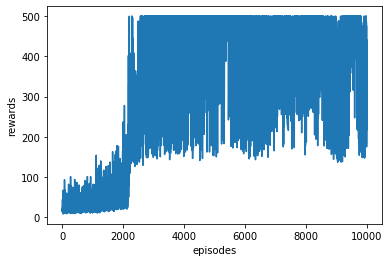

In [6]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('episodes')
plt.ylabel('rewards')

In [7]:
avg_reward = []
index = []
sum_ = 0
for i in range(len(rewards)):
    if(i%100 == 0):
        avg_reward.append(sum_/100)
        index.append(i+1)
        sum_ = 0
    sum_+=rewards[i]
avg_reward.append(sum_/100)
index.append(i+1)

Text(0, 0.5, 'rewards')

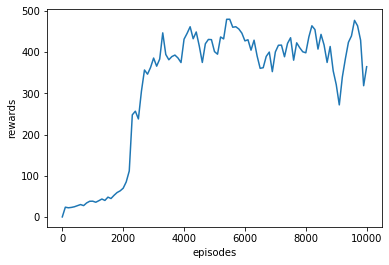

In [8]:
plt.plot(index,avg_reward)
plt.xlabel('episodes')
plt.ylabel('rewards')